In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder 


In [3]:
training_data = pd.read_csv('../data/cleaned_twitter_training.csv')
validation_data = pd.read_csv('../data/cleaned_twitter_validation.csv')

training_data = training_data.drop(training_data[training_data['sentiment'] == 'Positive'].sample(n=1000, random_state=42).index)

X_train = training_data['cleaned_tweet_content'].fillna("")
y_train = training_data['sentiment'].fillna("")
X_test = validation_data['cleaned_tweet_content'].fillna("")
y_test = validation_data['sentiment'].fillna("")

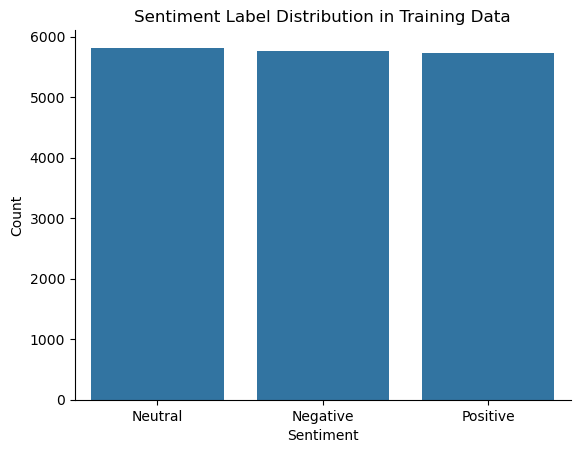

In [3]:
sentiment_counts = training_data['sentiment'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Label Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')

sns.despine()

plt.savefig('../visualizations/sentiment_distribution_3.png')
plt.show()

In [4]:
embeddings_index = {}

with open('../embeddings/glove.twitter.27B.200d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefficients

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193515 word vectors.


In [5]:
def get_embedding(text):
    if isinstance(text, str):
        words = text.split()
    embeddings = [embeddings_index.get(word)
                  for word in words
                  if embeddings_index.get(word) is not None]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(200)


X_train_embeddings = np.array([get_embedding(text) for text in X_train])
X_test_embeddings = np.array([get_embedding(text) for text in X_test])

In [47]:
model = RandomForestClassifier()
model.fit(X_train_embeddings, y_train)
y_pred = model.predict(X_test_embeddings)

joblib.dump(model, '../models/random_forest_model.joblib')

['../models/random_forest_model.joblib']

In [48]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1 Score:', f1_score(y_test, y_pred, average='weighted'))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.7037484885126964
Precision: 0.7054669108591102
Recall: 0.7037484885126964
F1 Score: 0.7039176520994944

Classification Report:
               precision    recall  f1-score   support

    Negative       0.69      0.75      0.72       265
     Neutral       0.65      0.64      0.65       285
    Positive       0.78      0.72      0.75       277

    accuracy                           0.70       827
   macro avg       0.71      0.71      0.70       827
weighted avg       0.71      0.70      0.70       827



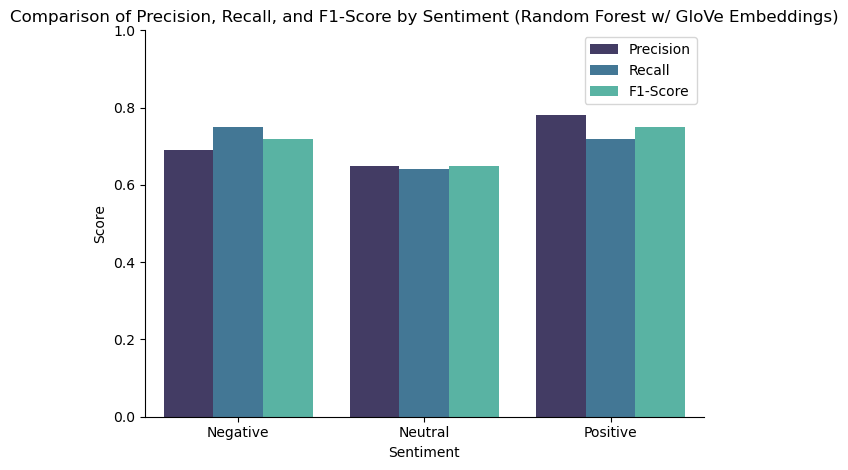

In [58]:
data = {
    'Category': ['Negative', 'Neutral', 'Positive', 'Negative', 'Neutral', 'Positive', 'Negative', 'Neutral', 'Positive'],
    'Metric': ['Precision', 'Precision', 'Precision', 'Recall', 'Recall', 'Recall', 'F1-Score', 'F1-Score', 'F1-Score'],
    'Score': [0.69, 0.65, 0.78, 0.75, 0.64, 0.72, 0.72, 0.65, 0.75]
}

df = pd.DataFrame(data)

sns.barplot(x='Category', y='Score', hue='Metric', data=df, palette='mako')

plt.title("Comparison of Precision, Recall, and F1-Score by Sentiment (Random Forest w/ GloVe Embeddings)")
plt.ylabel('Score')
plt.xlabel('Sentiment')

plt.ylim(0, 1.0)
plt.legend(bbox_to_anchor=(1, 1))

sns.despine()
plt.tight_layout()
plt.savefig('../visualizations/random_forest_sentiment_metrics_comparison')
plt.show()

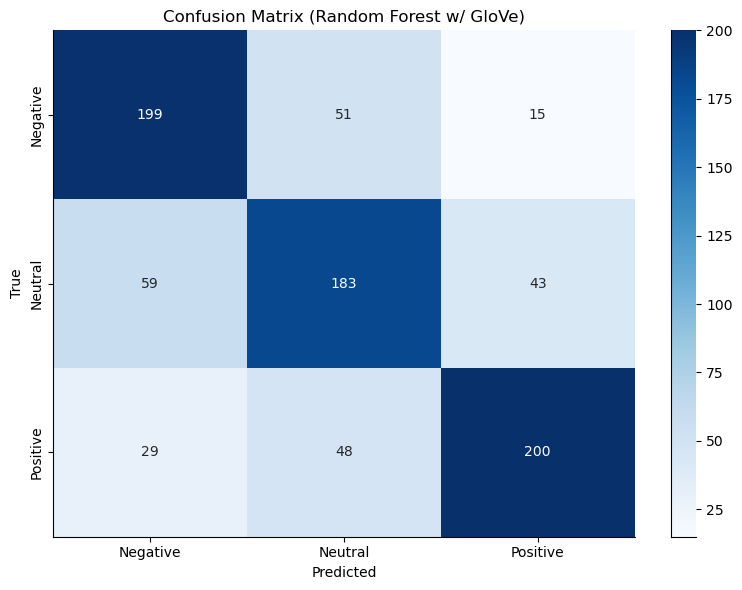

In [50]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Random Forest w/ GloVe)')

sns.despine()
plt.tight_layout()
plt.savefig('../visualizations/random_forest_confusion_matrix')
plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [6]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [7]:
inputs = tokenizer(list(X_train), return_tensors='pt', padding=True, truncation=True, max_length=128)
labels = torch.tensor(y_train_encoded, dtype=torch.long).to(device)

train_dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [30]:
optimizer = AdamW(model.parameters(), lr=2e-5)

model.train()
for epoch in range(3):
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

i:\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
model.save_pretrained('../models/bert_model')
tokenizer.save_pretrained('../models/bert_model')

In [8]:
# model = BertForSequenceClassification.from_pretrained('../models/bert_model')
# tokenizer = BertTokenizer.from_pretrained('../models/bert_model')

In [9]:
model.eval()

inputs = tokenizer(list(X_test), return_tensors='pt', padding=True, truncation=True, max_length=128)

inputs = {key: val.to(device) for key, val in inputs.items()}

with torch.no_grad():
    outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
    
logits = outputs.logits
y_pred = torch.argmax(logits, dim=1).cpu().numpy()

In [10]:
print('Accuracy:', accuracy_score(y_test_encoded, y_pred))
print('Precision:', precision_score(y_test_encoded, y_pred, average='weighted'))
print('Recall:', recall_score(y_test_encoded, y_pred, average='weighted'))
print('F1 Score:', f1_score(y_test_encoded, y_pred, average='weighted'))
print('\nClassification Report:\n', classification_report(y_test_encoded, y_pred))

Accuracy: 0.7363966142684402
Precision: 0.7379585620329279
Recall: 0.7363966142684402
F1 Score: 0.7356850534491728

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.74      0.73       265
           1       0.77      0.68      0.72       285
           2       0.73      0.80      0.76       277

    accuracy                           0.74       827
   macro avg       0.74      0.74      0.74       827
weighted avg       0.74      0.74      0.74       827



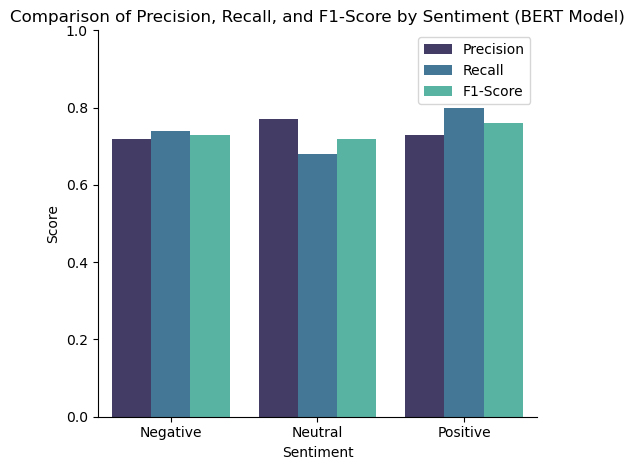

In [11]:
data = {
    'Category': ['Negative', 'Neutral', 'Positive', 'Negative', 'Neutral', 'Positive', 'Negative', 'Neutral', 'Positive'],
    'Metric': ['Precision', 'Precision', 'Precision', 'Recall', 'Recall', 'Recall', 'F1-Score', 'F1-Score', 'F1-Score'],
    'Score': [0.72, 0.77, 0.73, 0.74, 0.68, 0.80, 0.73, 0.72, 0.76]
}

df = pd.DataFrame(data)

sns.barplot(x='Category', y='Score', hue='Metric', data=df, palette='mako')

plt.title("Comparison of Precision, Recall, and F1-Score by Sentiment (BERT Model)")
plt.ylabel('Score')
plt.xlabel('Sentiment')

plt.ylim(0, 1.0)
plt.legend(bbox_to_anchor=(1, 1))

sns.despine()
plt.tight_layout()
plt.savefig('../visualizations/bert_sentiment_metrics_comparison')
plt.show()

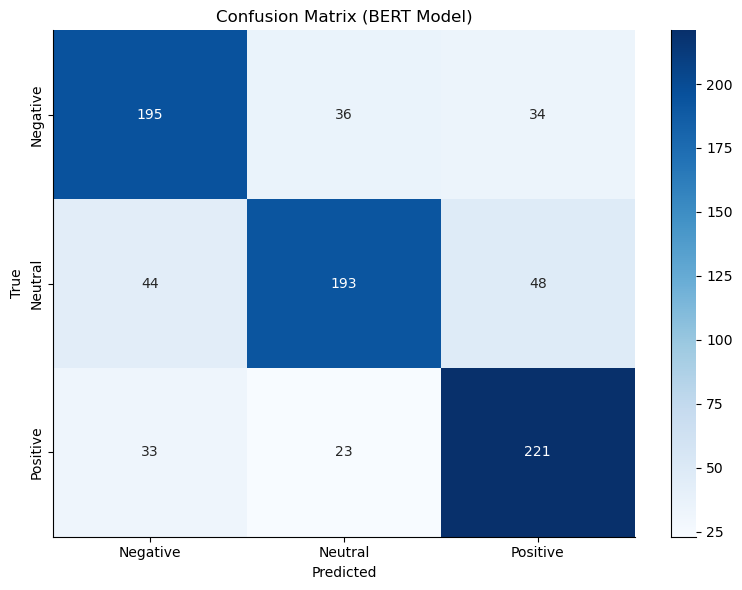

In [13]:
cm = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (BERT Model)')

sns.despine()
plt.tight_layout()
plt.savefig('../visualizations/bert_confusion_matrix')
plt.show()